In [1]:
import Random, Logging
using Gen, Plots, Distributions

# Disable logging, because @animate is verbose otherwise
Logging.disable_logging(Logging.Info);

In [30]:
@gen function sir_Simulation(N::Int, I0::Int)
    # Creating a Sir simulation that shows the spread of a disease in susceptible, infected and recovered people
    beta ~ normal(2, 1)
    gamma ~ normal(3, 1)

    Sn = N - I0
    In = I0
    Rn = 0

    sus = Float64[]
    inf = Float64[]
    rec = Float64[]

    t1 = Dict()
    t2 = Dict()
    
    i = 0
    while In > 0 && Sn > 0
        rate_of_transmission = beta * Sn * In / N
        rate_of_recovery = gamma * In
        rate_of_recovery = abs(rate_of_recovery)
        rate_of_transmission = abs(rate_of_transmission)
        t1[i] = exponential(rate_of_transmission)
        t2[i] = exponential(rate_of_recovery)
        if t1[i] < t2[i]
            Sn -= 1
            In += 1
        else
            In -= 1
            Rn += 1
        end

        push!(sus, Sn)
        push!(inf, In)
        push!(rec, Rn)
        i += 1
    end
    comb = hcat(sus, inf, rec)
    comb
end;


In [32]:
function create_real_data(N, I0)
    Random.seed!(1)
    beta = pop!(rand(Normal(5, 1), 1))
    gamma = pop!(rand(Normal(6, 1), 1))

    Sn = N - I0
    In = I0
    Rn = 0

    sus = Float64[]
    inf = Float64[]
    rec = Float64[]

    i = 0
    while In > 0 && Sn > 0
        rate_of_transmission = beta * Sn * In / N
        rate_of_recovery = gamma * In
        rate_of_recovery = abs(rate_of_recovery)
        rate_of_transmission = abs(rate_of_transmission)
        t1 = pop!(rand(Normal(rate_of_transmission), 1))
        t2 = pop!(rand(Normal(rate_of_recovery), 1))
       
        if t1 < t2

            Sn -= 1
            In += 1
        else
            In -= 1
            Rn += 1
        end

        push!(sus, Sn)
        push!(inf, In)
        push!(rec, Rn)
    end
    comb = hcat(sus, inf, rec)
    comb
end;

In [38]:
function make_infected_constraints(ys::Matrix{Float64})
    constraints = Gen.choicemap()
    for i=1:size(ys, 1)
        for j=1:size(ys, 2)
            constraints[:data => i => j => :y] = ys[i, j]
        end
    end
    constraints
end;

In [36]:
data = create_real_data(1000, 1)
print(typeof(data))

Matrix{Float64}

In [40]:
cons = make_infected_constraints(data);

In [41]:
function logmeanexp(scores)
    logsumexp(scores) - log(length(scores))
end;


In [42]:
traces  = [first(Gen.importance_resampling(sir_Simulation, (1000, 10), cons, 2000)) for i in 1:1000]

1000-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sir_Simulation#294", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:beta => Gen.ChoiceOrCallRecord{Float64}(2.9901578439048757, -1.4091448111278488, NaN, true), :gamma => Gen.ChoiceOrCallRecord{Float64}(2.3721246301657493, -1.1160522732269214, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -2.52519708435477, 0.0, (1000, 10), [989.0 11.0 0.0; 988.0 12.0 0.0; … ; 975.0 1.0 24.0; 975.0 0.0 25.0])
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sir_Simulation#294", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.Cho

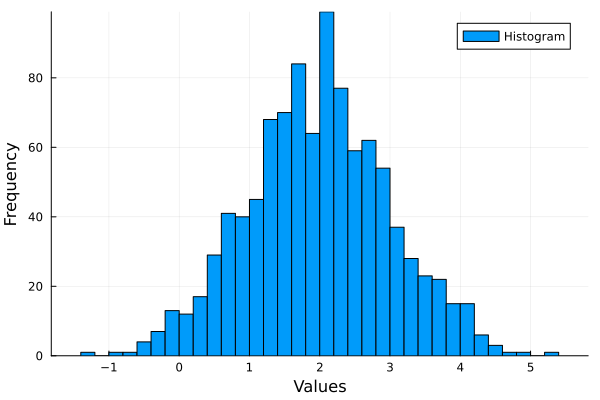

In [47]:
beta = Float64[]
gamma = Float64[]
for i in traces
    choices = get_choices(i)
    gamma_value = choices[:gamma]
    push!(gamma, gamma_value)
    beta_value = choices[:beta]
    push!(beta, beta_value)
    end

Plots.histogram(beta, bins=30, xlabel="Values", ylabel="Frequency", label="Histogram")

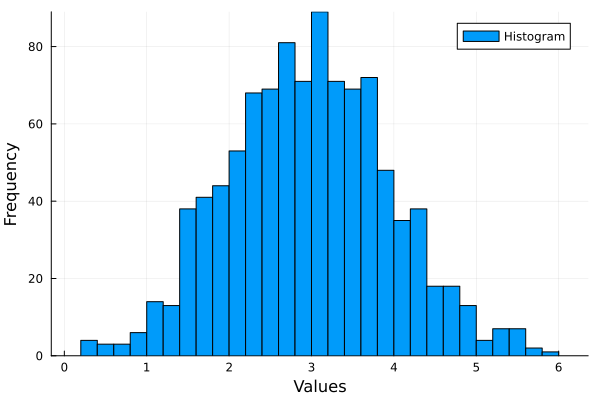

In [45]:
Plots.histogram(gamma, bins=30, xlabel="Values", ylabel="Frequency", label="Histogram")